## Information

Unfortunately, I was not able make the data loading/shuffleing/augmentation reproducible. Therefore running this notebook multiple times results in different results.

I had to run the notebook again at the end, and got different results what would be the best dropout rate to chose. 

My decision was based on a previous run and the comments added did fit to that run.

In [38]:
import os
import sys
import logging
import shutil

import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

from numba import cuda

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

workspace_dir = os.environ.get('WORKSPACE_DIR', '/workspace')

path_lib_dir = os.path.join(workspace_dir, 'lib')
# check if path has been added
if os.path.dirname(os.path.abspath(path_lib_dir)) not in sys.path:
    sys.path.append(path_lib_dir)

from lib.dataset import Dataset
from lib.augment import Processing

logging.basicConfig(level=logging.INFO)

# jupyter notebook make changes in imports to update without restarting kernel
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check TensorFlow version

In [2]:
tf.__version__

'2.14.0'

Check for GPU support

In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    device = cuda.get_current_device()
    device.reset()
else:
    print("GPU not available")

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

INFO:numba.cuda.cudadrv.driver:init
INFO:numba.cuda.cudadrv.driver:reset context of device 0


GPU is available
Default GPU Device: /device:GPU:0
Num GPUs Available:  1


2023-12-19 02:19:08.675686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 22981 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-12-19 02:19:08.676744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 22981 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5


Load the dataset

In [4]:
seed = 1234
# Set the seed for reproducibility
# tf.config.experimental.enable_op_determinism()

os.environ['PYTHONHASHSEED'] = '0'
tf.keras.utils.set_random_seed(seed)

dataset = Dataset(seed=seed, dataset_name='rock_paper_scissors')
dataset.load(validation_proportion=0.15)

ds_train = dataset.ds_train
ds_val = dataset.ds_val

# retrieve length of dataset from ds_train
len_ds_train = len(ds_train)
len_ds_val = len(ds_val)
len_ds_test = len(dataset.ds_test)

INFO:absl:Load dataset info from /root/tensorflow_datasets/rock_paper_scissors/3.0.0
INFO:absl:Reusing dataset rock_paper_scissors (/root/tensorflow_datasets/rock_paper_scissors/3.0.0)
2023-12-19 02:19:08.737909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22981 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5
INFO:absl:Constructing tf.data.Dataset rock_paper_scissors for split ['train'], from /root/tensorflow_datasets/rock_paper_scissors/3.0.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/rock_paper_scissors/3.0.0
INFO:absl:Reusing dataset rock_paper_scissors (/root/tensorflow_datasets/rock_paper_scissors/3.0.0)


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


INFO:absl:Constructing tf.data.Dataset rock_paper_scissors for split ['train[:2142]', 'train[2142:]', 'test'], from /root/tensorflow_datasets/rock_paper_scissors/3.0.0


Check number of images per split

In [5]:
len_ds_train, len_ds_val, len_ds_test

(2142, 378, 372)

In [6]:
# get cpu threads 
cpu_count = os.cpu_count()
workers = max(1, cpu_count - 2)
print('cpu_count', cpu_count)
print('workers', workers)

cpu_count 12
workers 10


Function for preparing the dataset

In [7]:
def prepare_dataset(ds, seed, target_size=(224, 224), batch_size=64, augment=True, shuffle=True):
    preprocessing = Processing(
        random_flip_left_right=True,
        random_brightness=0.1,
        random_contrast=0.1,
        random_rotation=180,
        random_saturation=0.1,
        random_hue=0.05,
        random_crop=0.05,
        random_translate=0.05,
        random_zoom=0.05,
    )
    ds_prepared = ds.cache()
    # ds_prepared = ds
    if shuffle:
        ds_prepared = ds_prepared.shuffle(len(ds_prepared), seed=seed)
    ds_prepared = preprocessing.preprocess(ds_prepared, target_size, augment)
    ds_prepared = ds_prepared.batch(batch_size)
    ds_prepared = ds_prepared.prefetch(tf.data.AUTOTUNE)
    return ds_prepared

In [8]:
overview_models = { }

Following best practice from
https://www.tensorflow.org/guide/keras/transfer_learning

Function for creating the model

In [9]:
def create_model(model_class, seed, target_size=(160, 160), dropout_rate=0.2, optimizer=tf.keras.optimizers.legacy.Adam()):
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(seed)
    input_shape=target_size + (3,)
    seed_init = seed
    base_model = model_class(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    # freeze base model
    base_model.trainable = False
    # set base model to inference mode (not training)
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # add head comparable to original MobileNetV2
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
     # add additional layers in case of dropout is not None
    if dropout_rate is not None:
        # Add a fully-connected layer
        seed_init += 1
        initializer = tf.keras.initializers.GlorotUniform(seed=seed_init)
        x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=initializer)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    seed_init += 1
    initializer = tf.keras.initializers.GlorotUniform(seed=seed_init)
    outputs = tf.keras.layers.Dense(3, activation='softmax', kernel_initializer=initializer)(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


Function for training the model

In [10]:
def train_model(
        model, 
        model_name, 
        overview_models, 
        ds_train, 
        ds_val,
        seed, 
        target_size, 
        workers,
        batch_size=64,
        epochs=20,
        callbacks=None,
        ):
    tf.keras.utils.set_random_seed(seed)
    ds_train_prepared = prepare_dataset(
        ds_train, seed, target_size=target_size, batch_size=batch_size, augment=True, shuffle=True)
    ds_val_prepared = prepare_dataset(
        ds_val, seed, target_size=target_size, batch_size=batch_size, augment=False, shuffle=False)

    #ds_train_prepared = ds_train_prepared.repeat()
    history = model.fit(
        ds_train_prepared,
        epochs=epochs,
        # batch_size=batch_size,
        validation_data=ds_val_prepared,
        workers=workers,
        callbacks=callbacks,
    )

    y_true = np.concatenate([y for x, y in ds_val_prepared], axis=0)
    y_pred = np.argmax(model.predict(ds_val_prepared), axis=1)
    cm = confusion_matrix(y_true, y_pred)

    overview_models[model_name] = {}
    overview_models[model_name]['model'] = model
    overview_models[model_name]['num_params'] = model.count_params()
    overview_models[model_name]['history'] = history.history
    overview_models[model_name]['cm'] = cm

    return overview_models


Function for plotting the history (dict for different models and histories)

In [11]:
def plot_history(overview_models, plot_model_size=True, ymin_accuracy=None, ymax_accuracy=None, ymin_loss=None, ymax_loss=None):
    nplot = 3 if plot_model_size else 2
    plt.figure(figsize=(nplot*6, 5))
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    alpha = 0.6
    # Plot training & validation accuracy values
    plt.subplot(1, nplot, 1)
    for i, (model_name, overview) in enumerate(overview_models.items()):
        history = overview['history']
        color = colors[i % len(colors)]
        plt.plot(history['accuracy'], label=f'{model_name} Train', linestyle='solid', color=color, alpha=alpha)
        plt.plot(history['val_accuracy'], label=f'{model_name} Validation', linestyle='dashed', color=color, alpha=alpha)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    if ymin_accuracy is not None:
        plt.ylim(ymin_accuracy, 1 if ymax_accuracy is None else ymax_accuracy)
        
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, nplot, 2)
    for i, (model_name, overview) in enumerate(overview_models.items()):
        history = overview['history']
        color = colors[i % len(colors)]
        plt.plot(history['loss'], label=f'{model_name} Train', linestyle='solid', color=color)
        plt.plot(history['val_loss'], label=f'{model_name} Validation', linestyle='dashed', color=color)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    if ymax_loss is not None:
        plt.ylim(0 if ymin_loss is None else ymin_loss, ymax_loss)
    plt.legend()

    if plot_model_size:
        # Plot model size vs validation accuracy in the last epoch
        plt.subplot(1, 3, 3)
        min_val = np.inf
        max_val = 0
        for i, (model_name, overview) in enumerate(overview_models.items()):
            history = overview['history']
            model_size = overview['num_params']
            val_accuracy_last_epoch = history['val_accuracy'][-1]
            plt.scatter(model_size, val_accuracy_last_epoch, color=colors[i % len(colors)], label=model_name, alpha=alpha)
            min_val = min(min_val, model_size)
            max_val = max(max_val, model_size)
        plt.title('Model size vs Validation accuracy')
        plt.xlim(min_val*0.9, max_val*1.1)
        plt.ylabel('Validation accuracy in the last epoch')
        plt.xlabel('Model size')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
def plot_cm(overview_models):
    num_models = len(overview_models)
    fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(3*num_models, 3))

    for ax, (model_name, model_info) in zip(axes, overview_models.items()):
        # Get the confusion matrix
        cm = model_info['cm']
        cm_normalized = normalize(cm, axis=1, norm='l1')

        cax = ax.matshow(cm_normalized, cmap=plt.cm.Blues)
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

        for i in range(cm_normalized.shape[0]):
            for j in range(cm_normalized.shape[1]):
                ax.text(j, i, f"{cm_normalized[i, j]:.2f}\n({cm[i, j]})", ha="center", va="center", color="red")

    plt.suptitle('Confusion Matrices, normalized value, absolute values in brackets')
    plt.tight_layout()
    plt.show()

## Selecting the base model

Selecting different base models for applying Transfer-Learning

In [13]:
func_mobilenetv2 = tf.keras.applications.MobileNetV2
func_densenet121 = tf.keras.applications.DenseNet121

target_size_mobilenetv2 = (160, 160)
target_size_densenet121 = (200, 200)

Training models using the smallest supported input image size for each base model.

In [14]:
epochs = 20
batch_size = 64
dropout_rate = None

logging.info(f'training model MobileNetV2')
model_mobilenetv2 = create_model(func_mobilenetv2, seed=seed, target_size=target_size_mobilenetv2, dropout_rate=dropout_rate)
overview = train_model(
    model_mobilenetv2, 
    'MobileNetV2', 
    overview_models, 
    ds_train, 
    ds_val, 
    seed, 
    target_size=target_size_mobilenetv2, 
    workers=workers,
    batch_size=batch_size,
    epochs=epochs,
)

logging.info(f'training model DenseNet121')
model_densenet121 = create_model(func_densenet121, seed=seed, target_size=target_size_densenet121, dropout_rate=dropout_rate)
overview = train_model(
    model_densenet121, 
    'DenseNet121', 
    overview_models, 
    ds_train, 
    dataset.ds_val, 
    seed, 
    target_size=target_size_densenet121, 
    workers=workers,
    batch_size=batch_size,  
    epochs=epochs,
)

INFO:root:training model MobileNetV2


Epoch 1/20


2023-12-19 02:19:18.114888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


34/34 [==============================] - 12s 201ms/step - loss: 0.7702 - accuracy: 0.6662 - val_loss: 0.4243 - val_accuracy: 0.8439
Epoch 2/20
34/34 [==============================] - 5s 148ms/step - loss: 0.2763 - accuracy: 0.9295 - val_loss: 0.2106 - val_accuracy: 0.9577
Epoch 3/20
34/34 [==============================] - 5s 151ms/step - loss: 0.1723 - accuracy: 0.9659 - val_loss: 0.1668 - val_accuracy: 0.9603
Epoch 4/20
34/34 [==============================] - 5s 148ms/step - loss: 0.1369 - accuracy: 0.9711 - val_loss: 0.1457 - val_accuracy: 0.9630
Epoch 5/20
34/34 [==============================] - 5s 150ms/step - loss: 0.1053 - accuracy: 0.9809 - val_loss: 0.1322 - val_accuracy: 0.9683
Epoch 6/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0901 - accuracy: 0.9827 - val_loss: 0.1080 - val_accuracy: 0.9656
Epoch 7/20
34/34 [==============================] - 5s 145ms/step - loss: 0.0782 - accuracy: 0.9851 - val_loss: 0.1034 - val_accuracy: 0.9735
Epoch 8/20
34/34

INFO:root:training model DenseNet121


Epoch 1/20
34/34 [==============================] - 21s 326ms/step - loss: 0.5284 - accuracy: 0.7890 - val_loss: 0.3177 - val_accuracy: 0.8995
Epoch 2/20
34/34 [==============================] - 7s 193ms/step - loss: 0.1755 - accuracy: 0.9510 - val_loss: 0.2388 - val_accuracy: 0.9233
Epoch 3/20
34/34 [==============================] - 7s 197ms/step - loss: 0.1261 - accuracy: 0.9715 - val_loss: 0.1878 - val_accuracy: 0.9312
Epoch 4/20
34/34 [==============================] - 7s 195ms/step - loss: 0.1145 - accuracy: 0.9753 - val_loss: 0.1556 - val_accuracy: 0.9550
Epoch 5/20
34/34 [==============================] - 7s 194ms/step - loss: 0.0892 - accuracy: 0.9827 - val_loss: 0.1507 - val_accuracy: 0.9497
Epoch 6/20
34/34 [==============================] - 7s 194ms/step - loss: 0.0874 - accuracy: 0.9832 - val_loss: 0.1467 - val_accuracy: 0.9392
Epoch 7/20
34/34 [==============================] - 7s 191ms/step - loss: 0.0833 - accuracy: 0.9837 - val_loss: 0.1124 - val_accuracy: 0.9709
Epoch

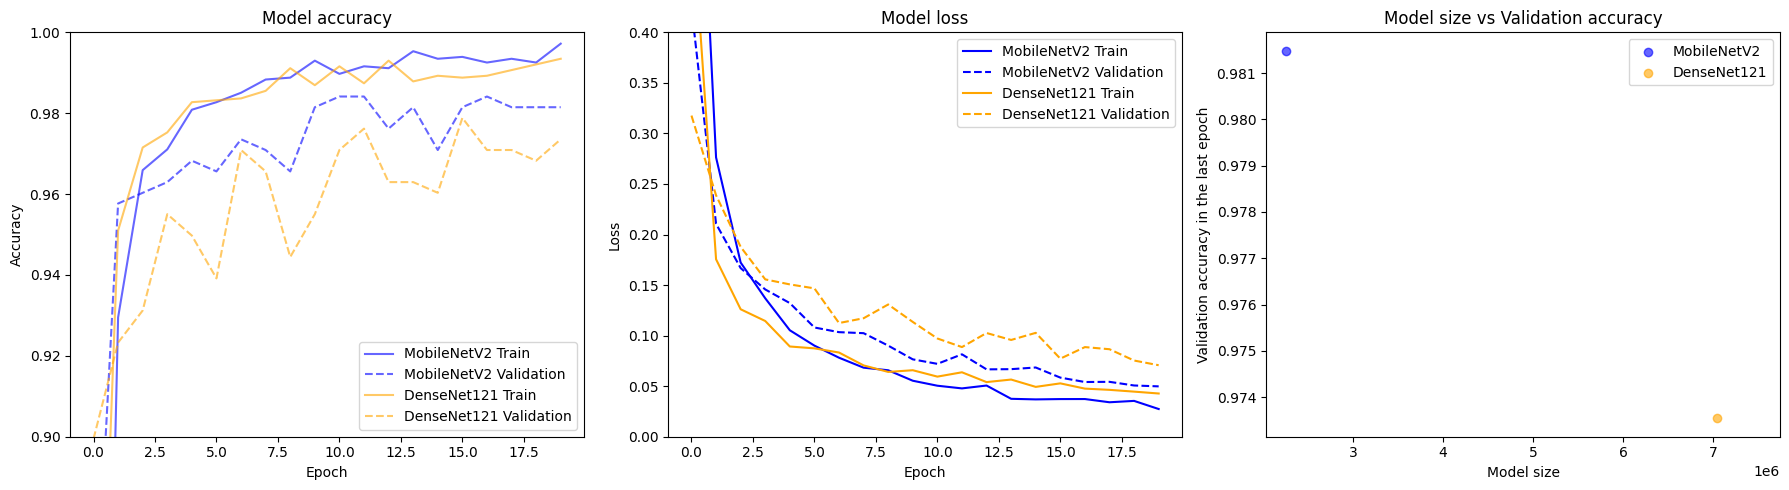

In [15]:
plot_history(overview_models, ymin_accuracy=0.9, ymax_loss=0.4)

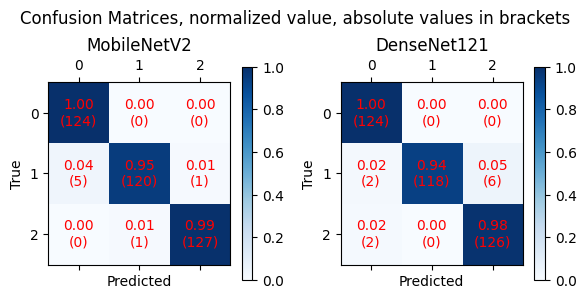

In [16]:
plot_cm(overview_models)

MobileNetv2 with input size (160,160) has less parameter than DenseNet121 with input size (200,200). Difference in performance (accuracy) is small. Therefore deciding to chose the smaller MobileNetv2 model for further investigations.


---

## Starting hyperparameter tuning

### Additional layer with different dropout rates

Trying out an additional layer with different dropout rates.

Furthermore comparing it to the model without addtional layer from previous training.

In [39]:
overview_mobilenetv2 = {}
overview_mobilenetv2['MobileNetV2'] = overview_models['MobileNetV2']

epochs=20
target_size=(160, 160)
batch_size=64

for dropout_rate in [0.0, 0.2, 0.4, 0.6]:
    logging.info(f'training model MobileNetV2 - additional layer with dropout {dropout_rate}')
    model_mobilenetv2_dropout = create_model(func_mobilenetv2, seed=seed, target_size=target_size, dropout_rate=dropout_rate)
    overview_mobilenetv2 = train_model(
        model_mobilenetv2_dropout, 
        f'MobileNetV2 dropout {dropout_rate}', 
        overview_mobilenetv2, 
        ds_train, 
        ds_val, 
        seed, 
        target_size=target_size, 
        workers=workers,
        batch_size=batch_size,
        epochs=epochs,
    )

INFO:root:training model MobileNetV2 - additional layer with dropout 0.0


Epoch 1/20
34/34 [==============================] - 11s 215ms/step - loss: 2.1259 - accuracy: 0.7446 - val_loss: 0.1830 - val_accuracy: 0.9471
Epoch 2/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0838 - accuracy: 0.9692 - val_loss: 0.0842 - val_accuracy: 0.9735
Epoch 3/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0533 - accuracy: 0.9818 - val_loss: 0.1291 - val_accuracy: 0.9630
Epoch 4/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0300 - accuracy: 0.9911 - val_loss: 0.0298 - val_accuracy: 0.9894
Epoch 5/20
34/34 [==============================] - 5s 145ms/step - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.0961 - val_accuracy: 0.9630
Epoch 6/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0228 - accuracy: 0.9944 - val_loss: 0.0588 - val_accuracy: 0.9762
Epoch 7/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0156 - accuracy: 0.9944 - val_loss: 0.0329 - val_accuracy: 0.9841
Epoch

INFO:root:training model MobileNetV2 - additional layer with dropout 0.2


Epoch 1/20
34/34 [==============================] - 10s 177ms/step - loss: 1.3765 - accuracy: 0.8147 - val_loss: 0.1214 - val_accuracy: 0.9497
Epoch 2/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0706 - accuracy: 0.9734 - val_loss: 0.0751 - val_accuracy: 0.9709
Epoch 3/20
34/34 [==============================] - 5s 145ms/step - loss: 0.0516 - accuracy: 0.9837 - val_loss: 0.0847 - val_accuracy: 0.9630
Epoch 4/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0284 - accuracy: 0.9907 - val_loss: 0.0399 - val_accuracy: 0.9841
Epoch 5/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0359 - accuracy: 0.9865 - val_loss: 0.0748 - val_accuracy: 0.9709
Epoch 6/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0218 - accuracy: 0.9935 - val_loss: 0.0723 - val_accuracy: 0.9735
Epoch 7/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0222 - accuracy: 0.9921 - val_loss: 0.0407 - val_accuracy: 0.9788
Epoch

INFO:root:training model MobileNetV2 - additional layer with dropout 0.4


Epoch 1/20
34/34 [==============================] - 10s 176ms/step - loss: 2.0396 - accuracy: 0.7488 - val_loss: 0.1425 - val_accuracy: 0.9497
Epoch 2/20
34/34 [==============================] - 5s 144ms/step - loss: 0.1114 - accuracy: 0.9622 - val_loss: 0.0786 - val_accuracy: 0.9630
Epoch 3/20
34/34 [==============================] - 5s 142ms/step - loss: 0.0560 - accuracy: 0.9813 - val_loss: 0.1067 - val_accuracy: 0.9656
Epoch 4/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0555 - accuracy: 0.9823 - val_loss: 0.0911 - val_accuracy: 0.9656
Epoch 5/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0343 - accuracy: 0.9893 - val_loss: 0.0717 - val_accuracy: 0.9709
Epoch 6/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0301 - accuracy: 0.9921 - val_loss: 0.0644 - val_accuracy: 0.9735
Epoch 7/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0301 - accuracy: 0.9907 - val_loss: 0.0509 - val_accuracy: 0.9762
Epoch

INFO:root:training model MobileNetV2 - additional layer with dropout 0.6


Epoch 1/20
34/34 [==============================] - 11s 177ms/step - loss: 1.5869 - accuracy: 0.7722 - val_loss: 0.2808 - val_accuracy: 0.9233
Epoch 2/20
34/34 [==============================] - 5s 143ms/step - loss: 0.1539 - accuracy: 0.9468 - val_loss: 0.0899 - val_accuracy: 0.9709
Epoch 3/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0903 - accuracy: 0.9715 - val_loss: 0.0672 - val_accuracy: 0.9735
Epoch 4/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0666 - accuracy: 0.9790 - val_loss: 0.0419 - val_accuracy: 0.9868
Epoch 5/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0608 - accuracy: 0.9795 - val_loss: 0.0610 - val_accuracy: 0.9709
Epoch 6/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0537 - accuracy: 0.9809 - val_loss: 0.0573 - val_accuracy: 0.9735
Epoch 7/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0391 - accuracy: 0.9893 - val_loss: 0.0624 - val_accuracy: 0.9762
Epoch

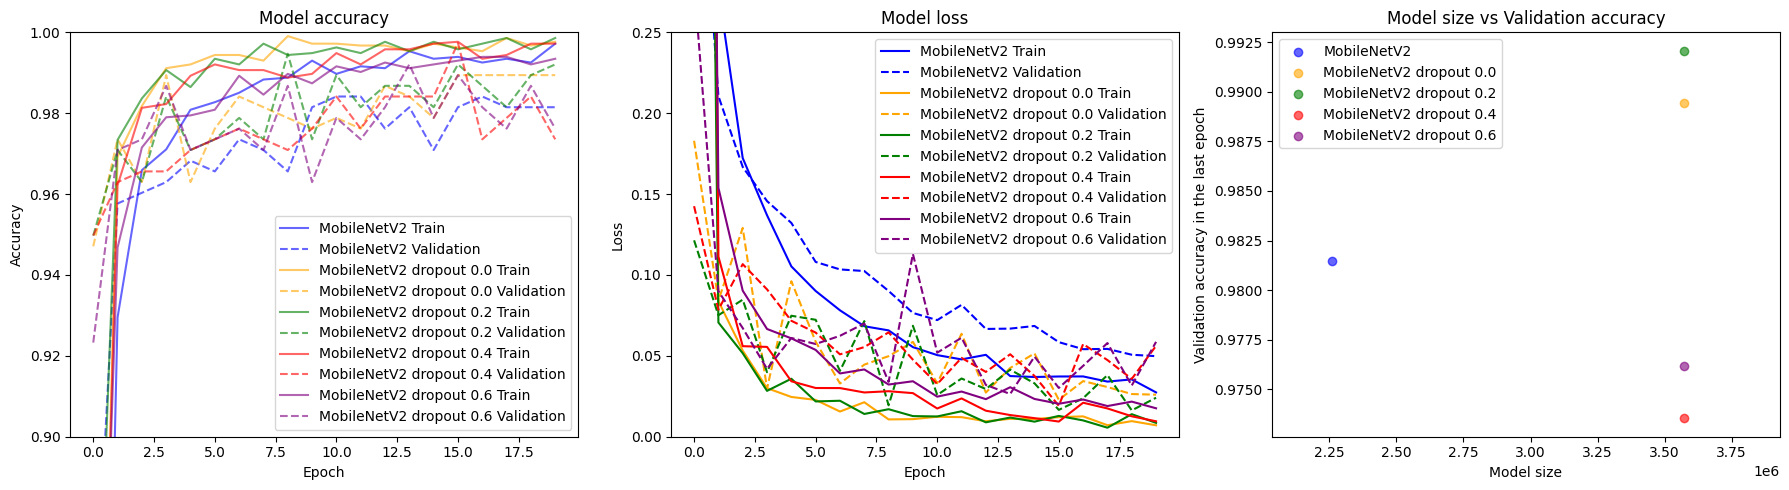

In [40]:
plot_history(
    overview_mobilenetv2, plot_model_size=True, 
    ymin_accuracy=0.9, ymax_accuracy=1.0,
    ymin_loss=0, ymax_loss=0.25
)

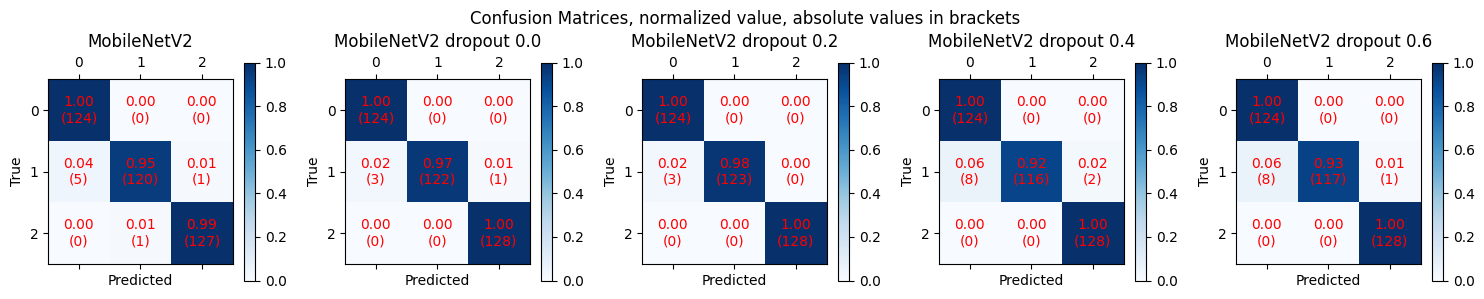

In [41]:
plot_cm(overview_mobilenetv2)

1. Model performance is more smooth for all models on training set as validation set.

1. Model without additional layer and and dropout has more smooth training curve than other models. But seems to learn more slowly than the others.

1. Selecting a moderate dropout of `0.4` as it has a good performance aftrer the last epoch. Higher dropout rate results in worse performance.

Next comparing performance to using learning rate decay.

In [20]:
dropout_rate=0.4
overview_mobilenetv2_lr_schedule = {}
overview_mobilenetv2_lr_schedule['MobileNetV2'] = overview_mobilenetv2[f'MobileNetV2 dropout {dropout_rate}']

epochs=20
target_size=(160, 160)
batch_size=64

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=epochs * 34,  # Total number of batches in 20 epochs
    decay_rate=(1e-4 / 1e-2) ** (1 / (20 * 34))  # Calculate decay rate
)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

model_mobilenetv2_lr_schedule = create_model(
    func_mobilenetv2, seed=seed, target_size=target_size, dropout_rate=dropout_rate, optimizer=optimizer)
overview_mobilenetv2_lr_schedule = train_model(
    model_mobilenetv2_lr_schedule, 
    'MobileNetV2 lr schedule', 
    overview_mobilenetv2_lr_schedule, 
    ds_train, 
    ds_val, 
    seed, 
    target_size=target_size, 
    workers=workers,
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
34/34 [==============================] - 11s 197ms/step - loss: 5.1400 - accuracy: 0.7148 - val_loss: 0.2334 - val_accuracy: 0.9603
Epoch 2/20
34/34 [==============================] - 5s 143ms/step - loss: 0.1376 - accuracy: 0.9561 - val_loss: 0.1766 - val_accuracy: 0.9683
Epoch 3/20
34/34 [==============================] - 5s 144ms/step - loss: 0.0718 - accuracy: 0.9725 - val_loss: 0.0970 - val_accuracy: 0.9709
Epoch 4/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0485 - accuracy: 0.9832 - val_loss: 0.0365 - val_accuracy: 0.9894
Epoch 5/20
34/34 [==============================] - 5s 146ms/step - loss: 0.0436 - accuracy: 0.9879 - val_loss: 0.0421 - val_accuracy: 0.9868
Epoch 6/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0465 - accuracy: 0.9865 - val_loss: 0.0407 - val_accuracy: 0.9868
Epoch 7/20
34/34 [==============================] - 5s 143ms/step - loss: 0.0509 - accuracy: 0.9832 - val_loss: 0.0241 - val_accuracy: 0.9921
Epoch

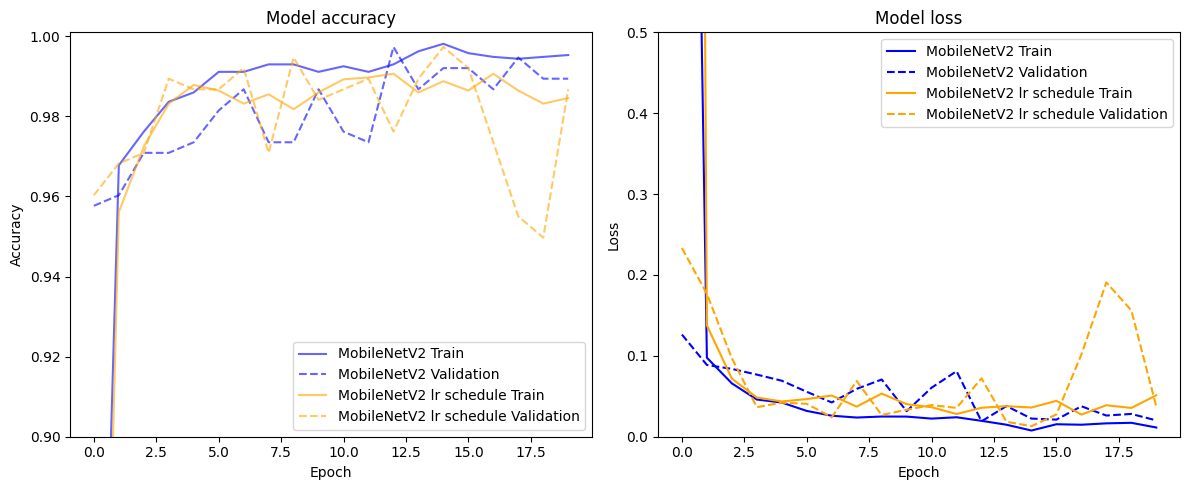

In [21]:
plot_history(
    overview_mobilenetv2_lr_schedule, plot_model_size=False, 
    ymin_accuracy=0.9, ymax_accuracy=1.001,
    ymin_loss=0, ymax_loss=0.5
)

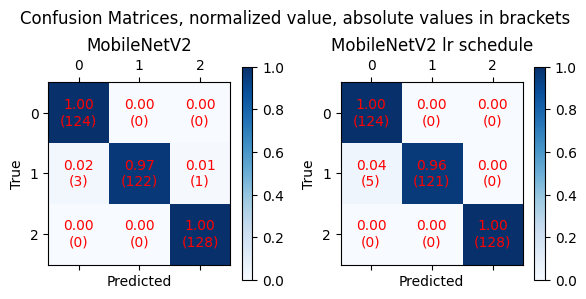

In [22]:
plot_cm(overview_mobilenetv2_lr_schedule)

The model trained using the learning rate schedule has a more "jumpy" curve for the valdidation split. 

Therefore deciding to not apply the learning rate schedule for the final model.

## Conclusion/Summary

The following has been tried out. Unfortunately, it was not possible to do the augmentation of the dataset in a reproducible way. Therefore running the notebook again could result in slightly different results.

1. **Different base models:**<br>
Training models based on different model architectures. MobileNetv2 has less parameters and performed better.
    - MobileNetv2 with input size (160,160)
    - DenseNet121 with input size (200,200)
    - Remark: DenseNet base model was not available for smaller images sizes
    - MobileNetv2 did perform better within `20` epochs and is smaller

1. **Additional Layer without and with different dropout rates:**<br>
Training MobileNetv2 models with and additional dense layer and different dropout rates and comparing it to the MobileNetv2 model for the previous step.
    - dropout rates `0.0`, `0.2`, `0.4`., and `0.6` have been tried out
    - Curves for validation accuracy are more 'jumpy' than for the 'original' model without the additional layer, but perform better within `20` epochs.
   - Chosing moderate dropout rate of `0.4`
     
1. **Differnt learning rates/schedules:**<br>
Training MobileNetv2 models (additional dense layer and dropout `0.4`) with and without learning rate decay. The model with learning rate decay has again a more 'jumpy' validation accuracy.
   - Selcecting the model without learning rate schedule

Final Model 

- MobileNetv2 with input size (160,160)
- with additional dense layer and dropout `0.4`
- no learning rate decay
- Stopping training after 10 epochs

Check performance on test dataset.

Training the final model using `train` and `validation` splits, but saving the best model based on `val_loss`. Afterwards choosing the best model for evaluating it finally with the `test` split.

In [23]:
from datetime import datetime
overview_final = {}

# clear all from memory of previous run
# prevent error from datetime import datetime
overview_final = {}

# clear all from memory of previous run
# prevent error from datetime import datetime
overview_final = {}

epochs=20
target_size = (160, 160)
batch_size = 64
dropout_rate = 0.4

path_model_dir = 'final_model'
shutil.rmtree(path_model_dir, ignore_errors=True)
# Check if the directory exists, and create it if not
# os.makedirs(path_model_dir, exist_ok=True)

# # Optional: Remove existing files in the directory
# existing_files = os.listdir(path_model_dir)
# for file_name in existing_files:
#     file_path = os.path.join(path_model_dir, file_name)
#     os.remove(file_path)
#     print(f"Removed existing file: {file_path}")
# Create a callback that saves the model's weights
checkpoint = ModelCheckpoint(
    filepath=os.path.join(path_model_dir, f'model_{datetime.now():%Y%m%d_%H%M%S}'+'-{epoch:02d}-{val_accuracy:.4f}.h5'), 
    monitor='val_accuracy',
    save_weights_only=True,
    verbose=1, 
    save_best_only=True, 
    mode='auto')

optimizer = tf.keras.optimizers.legacy.Adam()
final_model = create_model(func_mobilenetv2, seed=seed, target_size=target_size_mobilenetv2, dropout_rate=dropout_rate)
overview_final = train_model(
    final_model, 
    'MobileNetV2 final', 
    overview_final, 
    ds_train, 
    ds_val, 
    seed, 
    target_size=target_size, 
    workers=workers,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint],
)


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.3493 - accuracy: 0.7339
Epoch 1: val_accuracy improved from -inf to 0.94444, saving model to final_model/model_20231219_023254-01-0.9444.h5
34/34 [==============================] - 10s 180ms/step - loss: 2.3493 - accuracy: 0.7339 - val_loss: 0.1838 - val_accuracy: 0.9444
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9645
Epoch 2: val_accuracy improved from 0.94444 to 0.96561, saving model to final_model/model_20231219_023254-02-0.9656.h5
34/34 [==============================] - 5s 147ms/step - loss: 0.1126 - accuracy: 0.9645 - val_loss: 0.0898 - val_accuracy: 0.9656
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9767
Epoch 3: val_accuracy improved from 0.96561 to 0.97090, saving model to final_model/model_20231219_023254-03-0.9709.h5
34/34 [==============================] - 5s 146ms/step - loss: 0.0694 - accuracy: 0.9767 - val_loss: 

Loading model with best `val_loss` and evaluating it on the `validation` split.

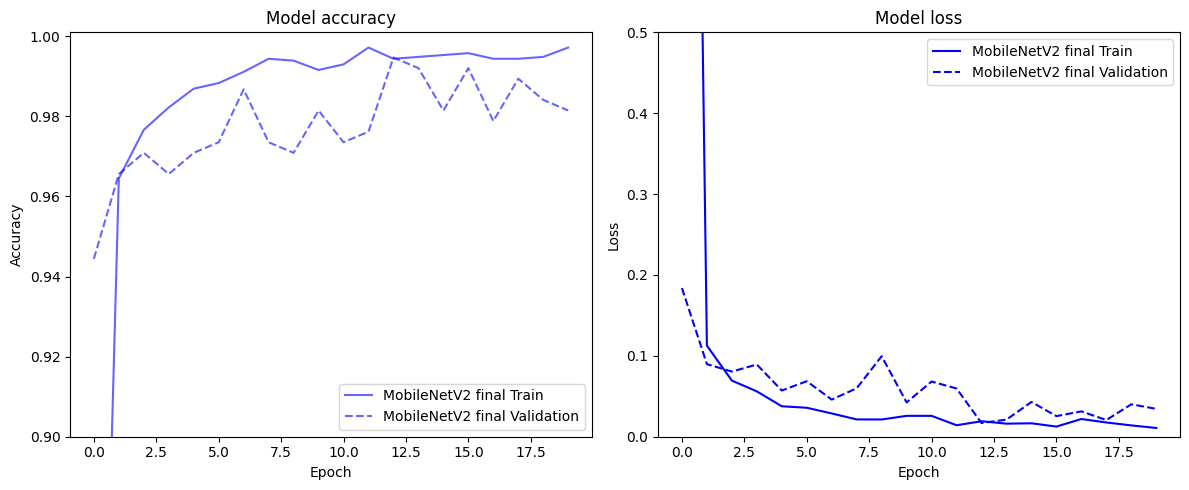

In [26]:
# plot overview_final
plot_history(
    overview_final, plot_model_size=False, 
    ymin_accuracy=0.9, ymax_accuracy=1.001,
    ymin_loss=0, ymax_loss=0.5
)

In [32]:
# get latest file in directory 
path_model_weights = os.path.join(path_model_dir, sorted(os.listdir(path_model_dir))[-1])
print(path_model_weights)
print(os.path.exists(path_model_weights))
print(os.path.exists(os.path.join(path_model_dir,'model.h5')))

final_model/model_20231219_023254-13-0.9947.h5
True
True


In [34]:
# final_model = tf.keras.models.load_model(os.path.join(path_model_dir,'model.h5'))

In [35]:
final_model.load_weights(path_model_weights)

6/6 [==============================] - 0s 24ms/step - loss: 0.0437 - accuracy: 0.9892
Evaluation on test data
Loss: 0.044
Accuracy: 0.989


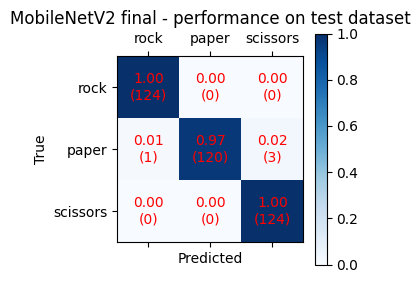

In [36]:
ds_test_prepared = prepare_dataset(dataset.ds_test, seed, target_size=target_size, batch_size=batch_size, augment=False, shuffle=False)
y_true = np.concatenate([y for x, y in ds_test_prepared], axis=0)
y_pred = np.argmax(final_model.predict(ds_test_prepared), axis=1)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
cm_normalized = normalize(cm, axis=1, norm='l1')

cax = ax.matshow(cm_normalized, cmap=plt.cm.Blues)
fig.colorbar(cax, ax=ax)
ax.set_title('MobileNetV2 final - performance on test dataset')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j, i, f"{cm_normalized[i, j]:.2f}\n({cm[i, j]})", ha="center", va="center", color="red")

# print labels
labels = dataset.ds_info.features['label'].names
num_labels = len(labels)
ax.set_xticks(np.arange(num_labels))
ax.set_yticks(np.arange(num_labels))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)


loss, accuracy = final_model.evaluate(ds_test_prepared)
print("Evaluation on test data")
print(f"Loss: {loss:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Exporting training logic to separate script [`train.py`](train.py).